# GCT to X-ID

What is the relationship between accuracy on the galaxy classification task (GCT) and accuracy on the cross-identification task?

In [43]:
import pickle, h5py, astropy.io.ascii as asc

with open('/Users/alger/data/Crowdastro/sets_atlas.pkl', 'rb') as f:
    atlas_sets = pickle.load(f)['RGZ & Norris']
with open('/Users/alger/data/Crowdastro/sets_swire.pkl', 'rb') as f:
    swire_sets = pickle.load(f)['RGZ & Norris']
with h5py.File('/Users/alger/data/Crowdastro/swire.h5') as f:
    swire_features = f['features'].value
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5') as f:
    swire_names = [i.decode('ascii') for i in f['/swire/cdfs/string'].value]
    swire_coords = f['/swire/cdfs/numeric'][:, :2]
swire_labels = {i['swire']: i['norris_label'] for i in asc.read('/Users/alger/data/SWIRE/all_labels.csv')}
table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')

In [35]:
import scipy.spatial

swire_tree = scipy.spatial.KDTree(swire_coords)

In [90]:
swire_name_to_index = {j:i for i, j in enumerate(swire_names)}

In [124]:
import sklearn.linear_model, random, crowdastro.crowd.util, numpy

# Generate some classifiers and test them.

accs_gct = []
accs_xid = []
distances = []
for size in [50, 50, 50, 50, 50, 50, 50, 100, 100, 100, 100, 100, 200, 200, 200, 400, 600, 800, 1200]:
    print(size)
    for (train, test), (atlas_train, atlas_test) in zip(swire_sets, atlas_sets):
        lr = sklearn.linear_model.LogisticRegression(C=1e10, class_weight='balanced')
        # Choose a subset.
        train = list(train)
        random.shuffle(train)
        while True not in {'True' == swire_labels[swire_names[n]] for n in train[:size]
                              if swire_labels[swire_names[n]]}:
            random.shuffle(train)
        train = train[:size]
        train_features = [swire_features[n] for n in train if swire_labels[swire_names[n]]]
        train_labels = ['True' == swire_labels[swire_names[n]] for n in train if swire_labels[swire_names[n]]]
        test_features = [swire_features[n] for n in test if swire_labels[swire_names[n]]]
        test_labels = ['True' == swire_labels[swire_names[n]] for n in test if swire_labels[swire_names[n]]]
        lr.fit(train_features, train_labels)
        
        # Test on SWIRE (GCT).
        pred_labels = lr.predict(test_features)
        ba = crowdastro.crowd.util.balanced_accuracy(test_labels, pred_labels)
        accs_gct.append(ba)
        
        # Test on ATLAS (X-ID).
        n_correct = 0
        n_total = 0
        distances_ = []
        for atlas in atlas_test:
            row = table[table['Key'] == atlas][0]
            ra = row['Component RA (Franzen)']
            dec = row['Component DEC (Franzen)']
            swire = row['Source SWIRE (Norris)']
            if not swire.startswith('SWIRE'):
                continue
            nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
            nearby_features = swire_features[nearby]
            if not nearby:
                continue
            atpreds = lr.predict_proba(nearby_features)[:, 1]
            names = [swire_names[n] for n in nearby]
            name = names[numpy.argmax(atpreds)]
            n_correct += name == swire
            n_total += 1
            true_coords = swire_coords[swire_name_to_index[swire]]
            pred_coords = swire_coords[swire_name_to_index[name]]
            distance = numpy.linalg.norm(true_coords - pred_coords)
            distances_.append(distance)
        distances.append(distances_)
        accs_xid.append(n_correct / n_total)

50


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


50
50
50
50
50
50
100
100
100
100
100
200
200
200
400
600
800
1200


In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

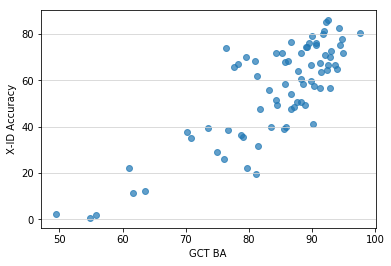

In [130]:
plt.scatter(numpy.array(accs_gct) * 100, numpy.array(accs_xid) * 100, marker='o', alpha=0.7)
plt.xlabel('GCT BA')
plt.ylabel('X-ID Accuracy')
plt.grid(color='lightgrey', axis='y')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid.pdf')

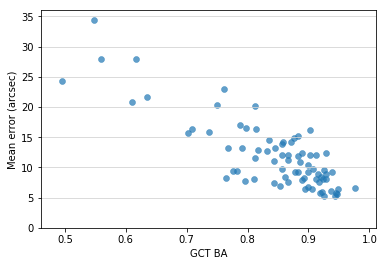

In [134]:
xs = []
ys = []
# yerr = []
for acc, distances_ in zip(accs_gct, distances):
    xs.append(acc)
    ys.append(numpy.mean(distances_) * 60 * 60)
#     yerr.append(numpy.std(distances_))
plt.grid(axis='y', color='lightgrey')
plt.scatter(xs, ys, marker='o', linestyle='None', linewidth=0.5, alpha=0.7)
plt.ylim((0, 0.01 * 60 * 60))
plt.ylabel('Mean error (arcsec)')
plt.xlabel('GCT BA')
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-arcsec-error.pdf')